In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, agent_state_dim, target_feature_dim, embed_dim=128, num_heads=4, distance_mode='log'):
        super(Attention, self).__init__()
        self.embed_dim = embed_dim
        self.distance_mode = distance_mode
        
        self.agent_encoder = nn.Sequential(
            nn.Linear(agent_state_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

        self.target_encoder = nn.Sequential(
            nn.Linear(target_feature_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

        self.agent_self_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm_agent = nn.LayerNorm(embed_dim)
        
        # Input cho lớp quyết định: Agent feat + Target feat + Distance
        self.assignment_attention = nn.Sequential(
            nn.Linear(embed_dim * 2 + 1, 256), 
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1) 
        )

    def forward(self, agent_states, global_targets, assignment_mode='gumbel', temperature=1.0):
        batch_size, num_agents, _ = agent_states.size()
        _, num_targets, _ = global_targets.size()

        agent_emb = self.agent_encoder(agent_states)      # [B, N, Emb]
        target_emb = self.target_encoder(global_targets)  # [B, M, Emb]

        # Self-attention giữa các agents
        agent_context, _ = self.agent_self_attn(query=agent_emb, key=agent_emb, value=agent_emb)
        agent_features = self.norm_agent(agent_emb + agent_context)
        
        # Tính khoảng cách
        a_pos = agent_states[:, :, :2].unsqueeze(2) # [B, N, 1, 2]
        t_pos = global_targets[:, :, :2].unsqueeze(1) # [B, 1, M, 2]
        dist_vec = a_pos - t_pos 
        dist = torch.norm(dist_vec, dim=-1, keepdim=True) # [B, N, M, 1]
        
        if self.distance_mode == 'log':
            dist_scalar = torch.log(dist + 1e-6)
        else:
            dist_scalar = dist

        # Expand dimensions để ghép nối (Concatenate)
        agent_features_exp = agent_features.unsqueeze(2).expand(-1, -1, num_targets, -1)
        target_emb_exp = target_emb.unsqueeze(1).expand(-1, num_agents, -1, -1)

        combined = torch.cat([agent_features_exp, target_emb_exp, dist_scalar], dim=-1)

        logits = self.assignment_attention(combined).squeeze(-1) # [B, N, M]

        if assignment_mode == 'gumbel':
            if self.training:
                weights = F.gumbel_softmax(logits, tau=temperature, hard=True, dim=-1)
            else:
                indices = torch.argmax(logits, dim=-1)
                weights = F.one_hot(indices, num_classes=num_targets).float()
        elif assignment_mode == 'soft': # <--- QUAN TRỌNG: Thêm nhánh này
            # Softmax trả về xác suất tổng bằng 1 (VD: [0.1, 0.7, 0.2])
            # Dùng để tính toán hình học có đạo hàm
            weights = F.softmax(logits / temperature, dim=-1) 
        else:
            weights = torch.sigmoid(logits)

        return weights, logits

In [11]:
import torch
import numpy as np

class SimulationEnv:
    def __init__(self, num_agents=4, num_targets=5, area_size=100.0, device='cpu'):
        self.num_agents = num_agents
        self.num_targets = num_targets
        self.area_size = area_size
        self.device = device
        
        # Cấu hình Target
        self.max_speed_target = 1.0
        
        # Cấu hình Camera Agent (PTZ)
        self.view_range = 40.0       # Tầm nhìn xa tối đa (Zoom)
        self.fov = np.deg2rad(60)    # Góc mở (Field of View) - 60 độ
        
        self.reset()

    def reset(self):
        # 1. Agents: 4 agent nằm ở 4 góc (cố định)
        # Góc: (0,0), (L,0), (0,L), (L,L)
        L = self.area_size
    
        self.agent_pos = torch.tensor(
            [[[0.0, 0.0],
              [L,   0.0],
              [0.0, L],
              [L,   L]]],
            device=self.device
        )
    
        # Khởi tạo góc quay (Pan angle) ngẫu nhiên [-pi, pi]
        self.agent_pan = (torch.rand(1, self.num_agents, device=self.device)
                          * 2 * np.pi) - np.pi
    
        # 2. Targets: Di chuyển ngẫu nhiên
        self.target_pos = (torch.rand(1, self.num_targets, 2, device=self.device)
                           * self.area_size)
    
        self.target_vel = ((torch.rand(1, self.num_targets, 2, device=self.device) - 0.5)
                           * 2 * self.max_speed_target)
    
        # Biến lưu trạng thái target nào đang được nhìn thấy
        self.visible_mask = torch.zeros(1, self.num_targets,
                                        dtype=torch.bool,
                                        device=self.device)
    
        # Cập nhật visibility ban đầu
        self._update_visibility()
    
        return self._get_state()


    def _get_state(self):
        """
        Trả về state cho model. 
        LƯU Ý: Che thông tin của các target không nhìn thấy (Partial Observability)
        """
        # 1. Agent State: [x, y, pan_angle, 0, 0] (Giữ shape 5 cho khớp model cũ)
        # Normalize góc về [-1, 1] cho dễ học (chia pi)
        pan_norm = self.agent_pan.unsqueeze(-1) / np.pi 
        agent_states = torch.cat([self.agent_pos, pan_norm, torch.zeros(1, self.num_agents, 2).to(self.device)], dim=-1)
        
        # 2. Target State: [x, y, vx, vy]
        # QUAN TRỌNG: Áp dụng Mask. Target nào không thấy thì gán bằng 0
        global_targets = torch.cat([self.target_pos, self.target_vel], dim=-1)
        
        # Expand mask để khớp shape (Batch, Targets, Features)
        mask_expanded = self.visible_mask.unsqueeze(-1).expand_as(global_targets)
        
        # Chỉ trả về thông tin target nhìn thấy, còn lại là 0
        masked_targets = global_targets * mask_expanded.float()
        
        # Thêm 1 feature nữa báo hiệu là "Visible" hay không (để model phân biệt 0 do bị che và 0 do ở gốc tọa độ)
        # Output shape: (Batch, M, 5) -> [x, y, vx, vy, is_visible]
        # *Lưu ý*: Bạn cần sửa model Attention input dim từ 4 lên 5 ở phần target_encoder
        visibility_feature = self.visible_mask.unsqueeze(-1).float()
        observed_targets = torch.cat([masked_targets, visibility_feature], dim=-1)
        
        return agent_states, observed_targets

    def _update_visibility(self):
        """Hàm vật lý tính toán xem Target nào đang nằm trong nón quan sát"""
        # Vector từ Agent đến Target: (1, N, M, 2)
        # a_pos: (1, N, 1, 2), t_pos: (1, 1, M, 2)
        diff = self.target_pos.unsqueeze(1) - self.agent_pos.unsqueeze(2) 
        dist = torch.norm(diff, dim=-1) # (1, N, M)
        
        # Tính góc từ Agent tới Target
        # atan2 trả về [-pi, pi]
        angle_to_target = torch.atan2(diff[:, :, :, 1], diff[:, :, :, 0])
        
        # Góc hiện tại của Agent: (1, N, 1)
        current_pan = self.agent_pan.unsqueeze(-1)
        
        # Tính độ lệch góc (Xử lý vấn đề quay vòng tròn 360 độ)
        # Ví dụ: Agent hướng 179 độ, Target ở -179 độ -> Lệch 2 độ chứ không phải 358 độ
        angle_diff = torch.abs(angle_to_target - current_pan)
        angle_diff = torch.min(angle_diff, 2*np.pi - angle_diff)
        
        # Điều kiện nhìn thấy:
        # 1. Khoảng cách < View Range
        # 2. Độ lệch góc < FOV / 2
        in_range = dist < self.view_range
        in_fov = angle_diff < (self.fov / 2.0)
        
        # Ma trận nhìn thấy chi tiết: Agent N có thấy Target M không?
        visibility_matrix = in_range & in_fov # (1, N, M)
        
        # Tổng hợp: Target M được coi là "Visible" nếu có ÍT NHẤT 1 Agent nhìn thấy
        self.visible_mask = visibility_matrix.any(dim=1) # (1, M)
        
        return visibility_matrix

    def step(self, assignment_weights):
        """
        assignment_weights: Output từ model.
        Ý nghĩa: Model chọn Target nào để Agent 'Focus' vào.
        Hành động: Agent xoay camera về phía Target được chọn (nếu Target đó đang visible hoặc dựa trên ký ức - ở đây ta giả lập xoay về vị trí thực)
        """
        # 1. Di chuyển Targets
        self.target_pos += self.target_vel
        for i in range(2):
            mask_lower = self.target_pos[:, :, i] < 0
            mask_upper = self.target_pos[:, :, i] > self.area_size
            self.target_vel[:, :, i][mask_lower | mask_upper] *= -1
            self.target_pos[:, :, i] = torch.clamp(self.target_pos[:, :, i], 0, self.area_size)

        # 2. Điều khiển Agent (Xoay Camera)
        # Tính toán vị trí mục tiêu mà Agent muốn nhìn
        # Lưu ý: Model chỉ đưa ra trọng số. Ở môi trường giả lập, ta dùng Ground Truth 
        # để xoay agent về đúng hướng target đó.
        target_destinations = torch.bmm(assignment_weights, self.target_pos) # (1, N, 2)
        
        # Tính góc cần quay tới
        direction = target_destinations - self.agent_pos
        desired_angle = torch.atan2(direction[:, :, 1], direction[:, :, 0])
        
        # Cập nhật góc quay của agent (Giả sử camera xoay ngay lập tức)
        # Nếu muốn thực tế hơn, có thể thêm tốc độ quay tối đa (max_rotation_speed)
        self.agent_pan = desired_angle

        # 3. Tính toán lại Visibility & Reward
        visibility_matrix = self._update_visibility()
        
        # Reward: Số lượng target ĐƯỢC NHÌN THẤY
        covered_count = self.visible_mask.sum().item()
        reward = covered_count / self.num_targets
        
        return self._get_state(), reward, covered_count

In [15]:
def compute_differentiable_coverage_loss(weights, agent_pos, target_pos, view_range):
    """
    Tính loss dựa trên hình học: Agent chọn target nào thì phải ở gần target đó.
    """
    # 1. Tính khoảng cách (B, N, M)
    dist_matrix = torch.cdist(agent_pos, target_pos, p=2)
    
    # 2. Điểm khả thi (Feasibility): Gần = 1, Xa = 0
    # view_range - dist: Nếu dương (trong tầm) -> sigmoid > 0.5
    feasibility = torch.sigmoid((view_range - dist_matrix))
    
    # 3. Sức mạnh bao phủ = Xác suất chọn * Khả năng nhìn thấy
    cover_strength = weights * feasibility
    
    # 4. Xác suất Target bị bỏ rơi (Miss Probability)
    prob_missed = torch.prod(1.0 - cover_strength, dim=1)
    
    # 5. Loss = Trung bình xác suất bị bỏ rơi (Minimize cái này)
    loss = torch.mean(prob_missed)
    
    return loss

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Arrow
from IPython.display import clear_output, display
import numpy as np
import time

def visualize_ptz_tracking(env, model, steps=200):
    """
    Hàm visualize dành riêng cho bài toán PTZ (Camera cố định, xoay góc)
    """
    # 1. Setup hình vẽ
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.close() # Đóng plot tĩnh ban đầu
    
    # 2. Reset môi trường
    agent_states, global_targets = env.reset()
    model.eval() # Chế độ đánh giá
    
    # Thông số vẽ
    fov_degrees = np.rad2deg(env.fov)
    view_range = env.view_range
    
    print("Đang khởi tạo Visualization...")
    
    for step in range(steps):
        # --- A. Lấy hành động từ Model ---
        with torch.no_grad():
            if isinstance(agent_states, tuple): agent_states = agent_states[0]
            
            # Dùng temperature thấp để lấy hành động "tốt nhất" model đã học
            weights, _ = model(agent_states, global_targets, assignment_mode='gumbel', temperature=0.1)
        
        # --- B. Step Environment ---
        (next_states, next_targets), reward, covered_count = env.step(weights)
        
        # --- C. Chuẩn bị dữ liệu vẽ (Chuyển sang CPU/Numpy) ---
        # Agent: Vị trí & Góc quay
        a_pos = env.agent_pos[0].cpu().numpy() # (N, 2)
        a_pan = env.agent_pan[0].cpu().numpy() # (N,) - Đơn vị: Radian
        
        # Target: Vị trí & Trạng thái nhìn thấy
        t_pos = env.target_pos[0].cpu().numpy() # (M, 2)
        visible_mask = env.visible_mask[0].cpu().numpy() # (M,) - True/False
        
        # --- D. Vẽ Hình ---
        ax.clear()
        ax.set_xlim(0, env.area_size)
        ax.set_ylim(0, env.area_size)
        ax.set_title(f"PTZ Tracking | Step: {step} | Reward: {reward:.2f}")
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # 1. VẼ CAMERA (AGENTS) & VÙNG NHÌN (WEDGES)
        for i in range(env.num_agents):
            # Chuyển đổi góc từ Radian sang Degree cho Matplotlib
            # Matplotlib 0 độ là hướng Đông (trục X dương), quay ngược chiều kim đồng hồ
            # Cần tính góc bắt đầu (theta1) và kết thúc (theta2) của rẻ quạt
            center_angle_deg = np.rad2deg(a_pan[i])
            theta1 = center_angle_deg - (fov_degrees / 2)
            theta2 = center_angle_deg + (fov_degrees / 2)
            
            # Vẽ rẻ quạt (Vùng nhìn thấy)
            fov_wedge = Wedge(
                center=(a_pos[i, 0], a_pos[i, 1]), 
                r=view_range, 
                theta1=theta1, 
                theta2=theta2, 
                color='blue', alpha=0.15
            )
            ax.add_patch(fov_wedge)
            
            # Vẽ đường tâm (Hướng nhìn chính diện)
            end_x = a_pos[i, 0] + view_range * np.cos(a_pan[i])
            end_y = a_pos[i, 1] + view_range * np.sin(a_pan[i])
            ax.plot([a_pos[i, 0], end_x], [a_pos[i, 1], end_y], 'b--', alpha=0.3)
            
            # Vẽ chấm vị trí Camera
            ax.scatter(a_pos[i, 0], a_pos[i, 1], c='blue', s=150, edgecolors='black', zorder=5, marker='s')

        # 2. VẼ TARGETS (Đổi màu dựa trên việc có bị nhìn thấy hay không)
        # Target được nhìn thấy -> Màu Xanh lá (Green)
        # Target bị mất dấu -> Màu Đỏ (Red)
        colors = ['lime' if visible else 'red' for visible in visible_mask]
        ax.scatter(t_pos[:, 0], t_pos[:, 1], c=colors, s=80, marker='^', edgecolors='black', zorder=4, label='Target')

        # Thống kê
        ax.text(0.02, 0.95, f"Covered: {covered_count}/{env.num_targets}", transform=ax.transAxes, fontsize=12, fontweight='bold')
        
        # --- E. Hiển thị ---
        display(fig)
        clear_output(wait=True)
        
        # Cập nhật state
        agent_states = next_states
        global_targets = next_targets

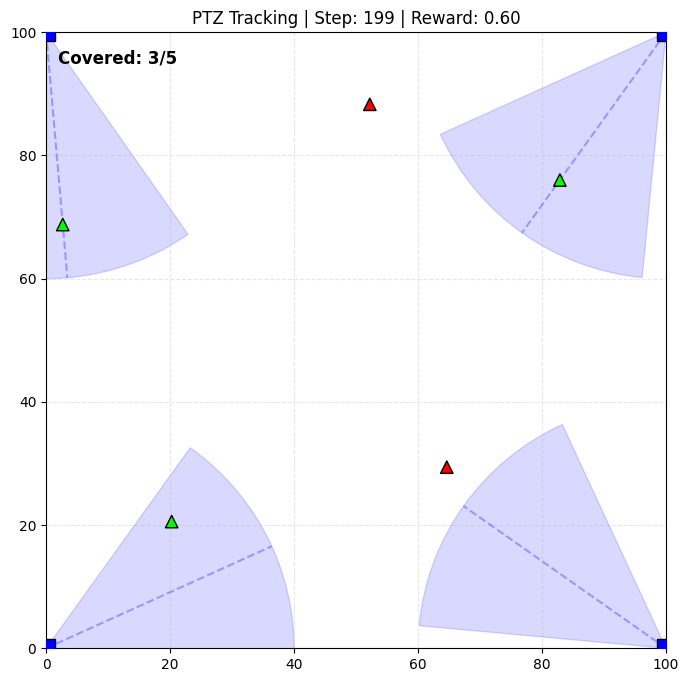

In [17]:
# --- 1. Sửa lại cấu hình ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_episodes = 300
steps_per_episode = 50

# Khởi tạo (Lưu ý: target_feature_dim=5 vì có thêm cột is_visible)
env = SimulationEnv(num_agents=4, num_targets=5, area_size=100.0, device=device)
model = Attention(agent_state_dim=5, target_feature_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
reward_history = []
loss_history = []

print("Bắt đầu training với Differentiable Loss (Hình học)...")

for episode in range(num_episodes):
    agent_states, global_targets = env.reset()
    episode_loss = 0
    episode_reward = 0
    
    for step in range(steps_per_episode):
        optimizer.zero_grad()
        
        if isinstance(agent_states, tuple): agent_states = agent_states[0]
        
        # --- BƯỚC 1: FORWARD (SOFT MODE) ---
        # Dùng 'soft' để có gradient truyền qua weights
        weights, logits = model(agent_states, global_targets, assignment_mode='soft', temperature=1.0)
        
        # --- BƯỚC 2: TÍNH LOSS TRỰC TIẾP ---
        # Lấy tọa độ (x, y) hiện tại để tính khoảng cách trong hàm loss
        curr_a_pos = agent_states[:, :, :2] # (B, N, 2)
        curr_t_pos = global_targets[:, :, :2] # (B, M, 2)
        
        # Gọi hàm loss mới
        loss = compute_differentiable_coverage_loss(
            weights, 
            curr_a_pos, 
            curr_t_pos, 
            view_range=env.view_range
        )
        
        # Backward & Update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # --- BƯỚC 3: STEP ENVIRONMENT (HARD MODE) ---
        # Môi trường cần quyết định dứt khoát (Index), không nhận xác suất lửng lơ
        # Chúng ta dùng torch.no_grad() để không ảnh hưởng đến gradient của bước train trên
        with torch.no_grad():
            action_indices = torch.argmax(weights, dim=-1) # Chọn target có prob cao nhất
            hard_weights = F.one_hot(action_indices, num_classes=env.num_targets).float()
            
            # Step môi trường để lấy thống kê và chuyển trạng thái vật lý
            (next_states, next_targets), reward, _ = env.step(hard_weights)
        
        # Cập nhật state
        agent_states = next_states
        global_targets = next_targets
        
        episode_loss += loss.item()
        episode_reward += reward # Reward này chỉ để log xem, không dùng để train

    # Logging
    avg_loss = episode_loss / steps_per_episode
    avg_reward = episode_reward / steps_per_episode
    
    loss_history.append(avg_loss)
    reward_history.append(avg_reward)
    
    if episode % 20 == 0:
        # Loss này sẽ LUÔN DƯƠNG và giảm dần về 0
        print(f"Ep {episode:3d} | Loss: {avg_loss:.4f} | Coverage thực tế: {avg_reward*100:.1f}%")

print("Training hoàn tất!")

visualize_ptz_tracking(env, model, steps=200)